In [1]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_masks_XYZ import Scalar_mask_XYZ
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.utils_math import ndgrid
from diffractio.utils_drawing import normalize_draw
from scipy.constants import c, epsilon_0, e, m_e, h
import numpy as np
import sympy as sp

from sympy.core.numbers import pi
from IPython.display import display
import numba
from numbalsoda import dop853, lsoda, lsoda_sig
from numba import njit, cfunc

%matplotlib widget

Here we ware going to use a light optics package to calculate the path of the electron. We can do this because in purely electrostatic systems, there is an electrostatic analogue of snells law. We can use this to test if the optical path length calculations of our ray tracing model actually work. We will test it again at a scale that for now is not physically accurate. If our ray tracing model recreates the fringe spacing, then we know that our optical path length calculations will work. 

In [2]:
#Use scipy's constants
e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0/1e-6 #8.85418782e-12 #permittivity unit F/m
eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

#Set initial accelerating voltage. I know it's unrealistic but it gives an output that is easy to plot for now.
phi_0 = 200e3

wavelength = h_planck/(2*abs(e)*m*phi_0)**(1/2)/1e-6
print(wavelength)

#Charge parameter for wire
K_val = 3.31 #unit e/nm - convert to coulombs per m? 
K_val_SI = (3.31*abs(e))/1e-9/1e-6 #C/m to C/um

X, Y, Z, K, eps_0, c, h = sp.symbols('x y z K epsilon_0 c h')
a, b = sp.symbols('a b')

phi_wires_pozzi = (K/(4*pi*eps_0))*((sp.asinh((c-(X-h))/sp.sqrt(Y**2+Z**2)))-(sp.asinh((-c-(X-h))/sp.sqrt(Y**2+Z**2)))+(sp.asinh((-c-(X+h))/sp.sqrt(Y**2+Z**2)))-(sp.asinh((c-(X+h))/sp.sqrt(Y**2+Z**2))))
display(phi_wires_pozzi)

2.742371829700478e-06


K*(asinh((-c - h - x)/sqrt(y**2 + z**2)) - asinh((-c + h - x)/sqrt(y**2 + z**2)) - asinh((c - h - x)/sqrt(y**2 + z**2)) + asinh((c + h - x)/sqrt(y**2 + z**2)))/(4*pi*epsilon_0)

In [3]:

#Define wire length using pozzi's notation
c_val = 0.5e-3/1e-6

#Define gap
gap = 90e-9/1e-6

#Define h_val from pozzi
h_val = -(c_val+gap)

phi_wires_pozzi = phi_wires_pozzi.subs({K:K_val_SI, eps_0:eps_0_val, pi:np.pi, c:c_val, h:h_val})


#Here we write the "refractive index" that the electron would see, using the equation for the electrostatic potential. See Eq 5.17 in Hawkes Principles of Electron Optics
n_eq1 = (1+phi_wires_pozzi/phi_0)**(0.5)
n_eq1_lambda = sp.lambdify([X, Y, Z], n_eq1)

#The equation needs to be written as a string for diffractio to be able to implement it, and we need to replace log with np.log in the expression.
#This is because diffractio uses the "eval" function which uses a string to form the function.
n = str(n_eq1).replace("log", "np.log")

#Set up the scale in x and z
x0 = np.linspace(-0.2 * um, 0.2 * um, 100 * 1)
y0 = np.linspace(-0.2 * um, 0.2 * um, 100 * 1)
z0 = np.linspace(-0.2 * um, 0.2 * um, 200)
xx0, yy0, zz0 = ndgrid(x0, y0, z0)

#Create a source plane wave
u0 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
u0.plane_wave(A=1, z0=0 * um, theta=0. * degrees)

t0 = Scalar_mask_XYZ(x=x0, y=y0, z=z0, wavelength=wavelength, n_background=1)
t0.incident_field(u0)

#Create the biprism volume
t0.n = np.complex128(n_eq1_lambda(xx0, yy0, zz0))

wire_r = 0.01 * um
#Make top cylinder to cover wire
idxr = (t0.Y)**2 / wire_r**2 + (t0.Z)**2 / wire_r**2 <= 1
#idx1 = t0.X >= -h_val - c_val
#idx2 = t0.X <= -h_val + c_val
idx = idxr# * idx1 * idx2

t0.n[idx] = 1.0 + 1.0j



/tmp/ipykernel_73574/3495891423.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xx0[idx], yy0[idx], zz0[idx], '.k', color='blue', alpha=0.2)


Text(0.5, 0, 'z')

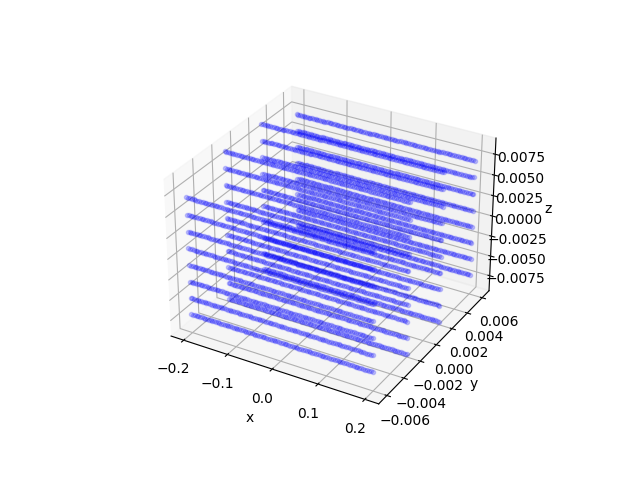

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xx0[idx], yy0[idx], zz0[idx], '.k', color='blue', alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

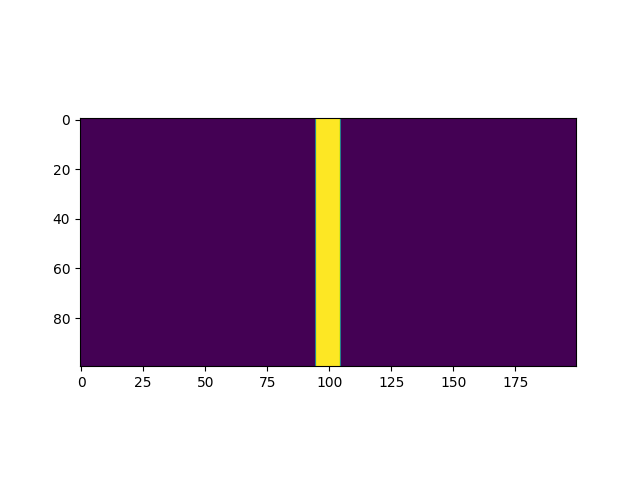

In [33]:
plt.figure()
plt.imshow(np.abs(t0.n[:, 50, :]))

Plot the results

In [21]:
#Perform the calculation with the wave propagation method
t0.WPM(verbose=True, has_edges=False)

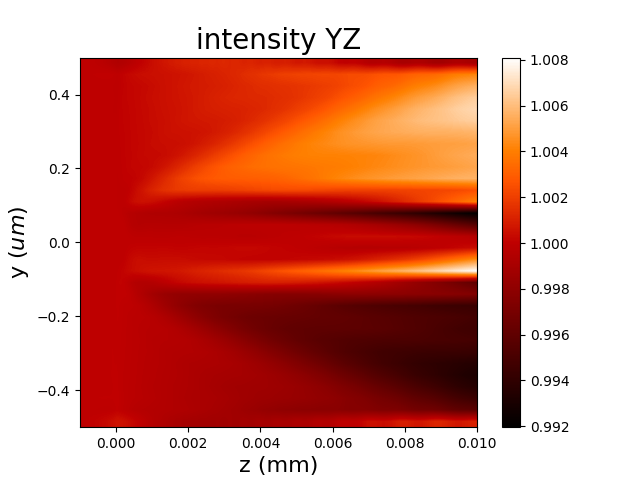

In [17]:
t0.draw_YZ(x0=0, draw_borders=True)

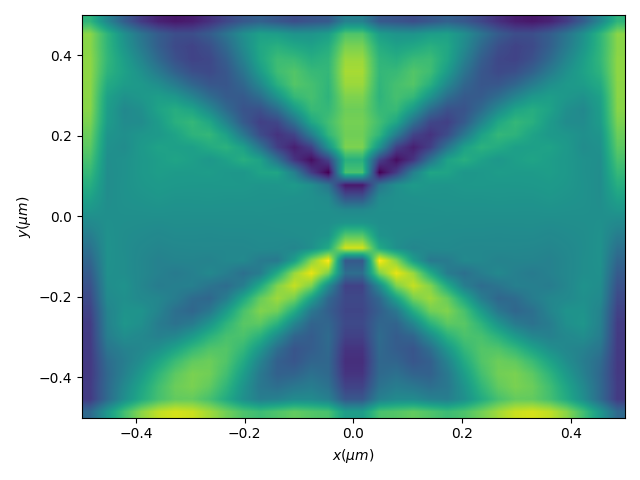

In [18]:
u_xy = t0.to_Scalar_field_XY(z0=10 * um, is_class=False, matrix=True)

plt.figure()
intensity = normalize_draw(np.abs(u_xy.T)**2, False, 'maximum')
extension = (x0[0], x0[-1], y0[0], y0[-1])

IDimage = plt.imshow(intensity,
                        interpolation='bilinear',
                        aspect='auto',
                        origin='lower',
                        extent=extension)

plt.xlabel(xlabel="$x  (\mu m)$")
plt.ylabel(ylabel="$y  (\mu m)$")
plt.axis(extension)
plt.tight_layout()



This method works but it's only just about sampled enough. We can better if we do the calculation in place so we don't run into storage issues.

In [5]:
def fn(x, y, z, wavelength):
    xx, _ = ndgrid(x, y)
    n = np.complex128(n_eq1_lambda(xx, y, z))
    n[xx**2 / R**2 + z**2 / R**2 > 1] = 1.0 + 0.0j
    n[xx**2 / r**2 + z**2 / r**2 <= 1] = 1.0 + 10.0j
    
    return np.squeeze(n)

Now we have a baseline, we should be able to recreate it with our optical path length ray tracing code, and will achieve the same fringe spacing if our code works.

Again setup all equations and functions.

In [26]:
x = np.linspace(-0.8 * um, 0.8 * um, 256)
y = np.linspace(-0.8 * um, 0.8 * um, 256)
z = np.linspace(-1 * mm, 80 * mm, 8192 * 16)

u0 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
u0.plane_wave(A=1, theta=0. * degrees)

t_iter = Scalar_mask_XY(x=x0, y=y0, wavelength=wavelength)
t_iter.incident_field(u0)

t_iter.WPM(fn, z_ini=z[0], z_end= z[-1], dz=(z[-1]-z[0])/len(z),
                            has_edges=False, matrix=False, verbose=True)




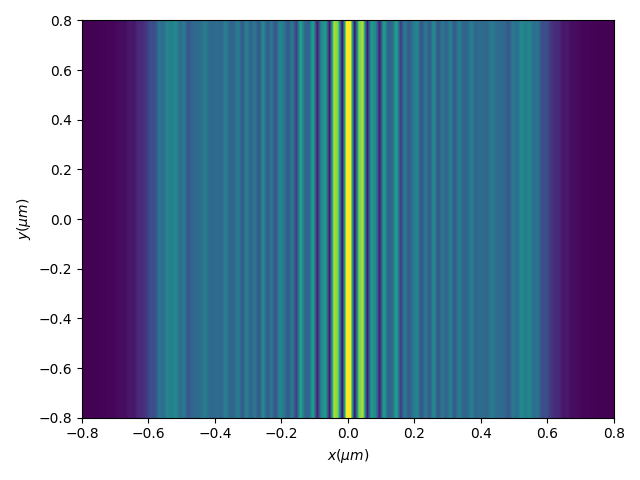

In [14]:
u_iter = t_iter.u

plt.figure()
intensity = normalize_draw(np.abs(u_iter.T)**2, False, 'maximum')
extension = (x0[0], x0[-1], y0[0], y0[-1])

IDimage = plt.imshow(intensity,
                        interpolation='bilinear',
                        aspect='auto',
                        origin='lower',
                        extent=extension)

plt.xlabel(xlabel="$x  (\mu m)$")
plt.ylabel(ylabel="$y  (\mu m)$")
plt.axis(extension)
plt.tight_layout()



In [50]:
def make_potential_and_efield(phi, phi_0, x, y, z):
    
    phi_hat = (phi_0+phi)#*(1+eps*(phi_0-phi))
    
    #Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
    dphi_hat_wires_electron_dx = phi_hat.diff(x)
    dphi_hat_wires_electron_dy = phi_hat.diff(y)
    dphi_hat_wires_electron_dz = phi_hat.diff(z)
    phi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], phi_hat, 'numpy'), nopython = True)
    dphi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], [dphi_hat_wires_electron_dx, dphi_hat_wires_electron_dy, dphi_hat_wires_electron_dz], 'numpy'), nopython = True)
    
    return phi_hat_wires_electron_lambda, dphi_hat_wires_electron_lambda

phi_hat_lambda, dphi_hat_lambda = make_potential_and_efield(phi_wires_pozzi, phi_0, X, Y, Z)

@cfunc(lsoda_sig)
def trajectory_equation_of_motion_numba(z, x, dx, phi_hat_0):
    
    p = (1+x[1]**2+x[3]**2)**(1/2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    dx[0] = x[1]
    dx[1] = (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z)
    dx[2] = x[3]
    dx[3] = (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z)
    dx[4] = (phi_hat/phi_hat_0[0])**(1/2)*p

In [56]:
macro_block_size = 16
n_threads = 64
scale = 1
n = (n_threads*macro_block_size*scale)**2
num_along_dim = int(np.sqrt(n))
print(n)
print(num_along_dim)

1048576
1024


In [66]:
x0 = np.linspace(-0.8, 0.8, num_along_dim, dtype = np.float64, endpoint=True)
y0 = np.linspace(-0.8, 0.8, num_along_dim, dtype = np.float64, endpoint=True)

grid = np.array(np.meshgrid(x0, y0))
pos_0 = grid.reshape(2, n).T

z_eval = np.array([-1 * um, 0, 10 * um])

#Need the potential at the beginning for the optical path length calculation.
phi_hat_lambda_0 = phi_hat_lambda(0, y0[0], z_eval[0])

#We need to assign the equation for numbalsoda to an address in memory.
rhs = trajectory_equation_of_motion_numba
funcptr = rhs.address

In [67]:
from numba_progress import ProgressBar

@numba.njit(nogil=True, parallel=True)
def main(n, pos_0, phi_hat_lambda_0, n_threads, macro_block_size, progress_proxy):
    
    x_out = np.empty((n,len(z_eval)), np.float64)
    y_out = np.empty((n,len(z_eval)), np.float64)
    opl_out = np.empty((n,len(z_eval)), np.float64)
    n_threads = n_threads #Number of threads on laptop cpu
    thread_block_size = int(n/n_threads)
    macro_block_size = macro_block_size
    macro_blocks = int(thread_block_size/macro_block_size)
    
    for thread in numba.prange(n_threads):
        thread_idx = thread*thread_block_size
        
        for macro_block in range(macro_blocks):
                #get starting index for the block of rays of each macroblock in a thread.
                macro_block_idx = macro_block*macro_block_size
                
                #combine the starting index of the thread and macroblock
                idx_start = thread_idx + macro_block_idx
                
                for j in range(macro_block_size):
                    u0 = np.empty((5,), np.float64)
                    
                    u0[0] = pos_0[idx_start+j, 0]
                    u0[1] = 0.
                    u0[2] = pos_0[idx_start+j, 1]
                    u0[3] = 0.
                    u0[4] = 0.
                    
                    usol, success = lsoda(funcptr, u0, z_eval, data = phi_hat_lambda_0, rtol = 1.0e-10, atol = 1.0e-17)
                    
                    x_out[idx_start+j] = usol[:,0]
                    y_out[idx_start+j] = usol[:,2]
                    opl_out[idx_start+j] = usol[:,4]

                    progress_proxy.update(1)
                    
    return x_out, y_out, opl_out

with ProgressBar(total=n) as progress:
    x_out, y_out, opl_out = main(n, pos_0, np.array([phi_hat_lambda_0]), n_threads, macro_block_size, progress)
    

  0%|          | 0/1048576 [00:00<?, ?it/s]

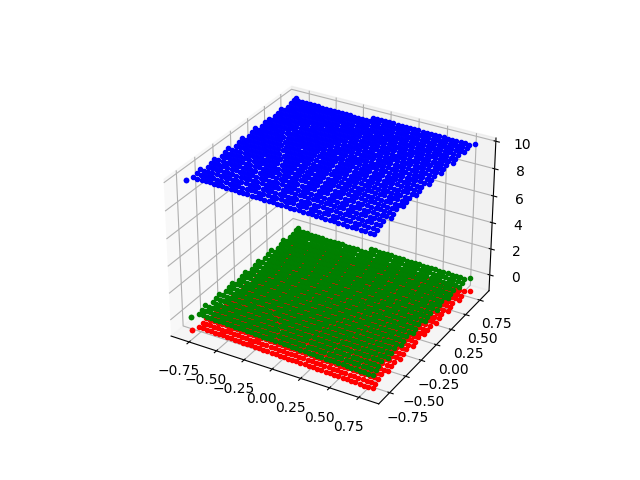

In [68]:
fig = plt.figure()
ax = plt.axes(projection='3d')

def get_scale(x_out, y_out):
    x_left = np.argmin(x_out)
    x_right = np.argmax(x_out)
    y_bottom = np.argmin(y_out)
    y_top = np.argmax(y_out)
    
    return x_out[x_left], x_out[x_right], y_out[y_bottom], y_out[y_top]

def plot_extent(ax, x_out, y_out, z_eval, c):
    
    x_left, x_right, y_bottom, y_top = get_scale(x_out, y_out)
    
    ax.plot(x_left, y_bottom, z_eval, c)
    ax.plot(x_left, y_top, z_eval, c)
    ax.plot(x_right, y_top, z_eval, c)
    ax.plot(x_right, y_bottom, z_eval, c)
    ax.plot(x_out[::1000], y_out[::1000], z_eval, c)

    
plot_extent(ax, x_out[:, 0], y_out[:, 0], z_eval[0], '.r')
plot_extent(ax, x_out[:, 1], y_out[:, 1], z_eval[1], '.g')
plot_extent(ax, x_out[:, -1], y_out[:, -1], z_eval[-1], '.b')



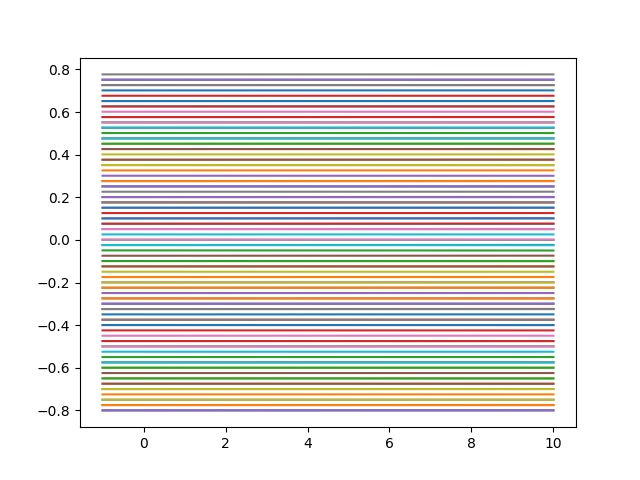

In [70]:
z_out = np.tile(z_eval,(x_out.shape))[:, 0:x_out.shape[1]]
fig, ax = plt.subplots()
ax.plot(z_out[::10000, :].T, x_out[::10000, :].T)

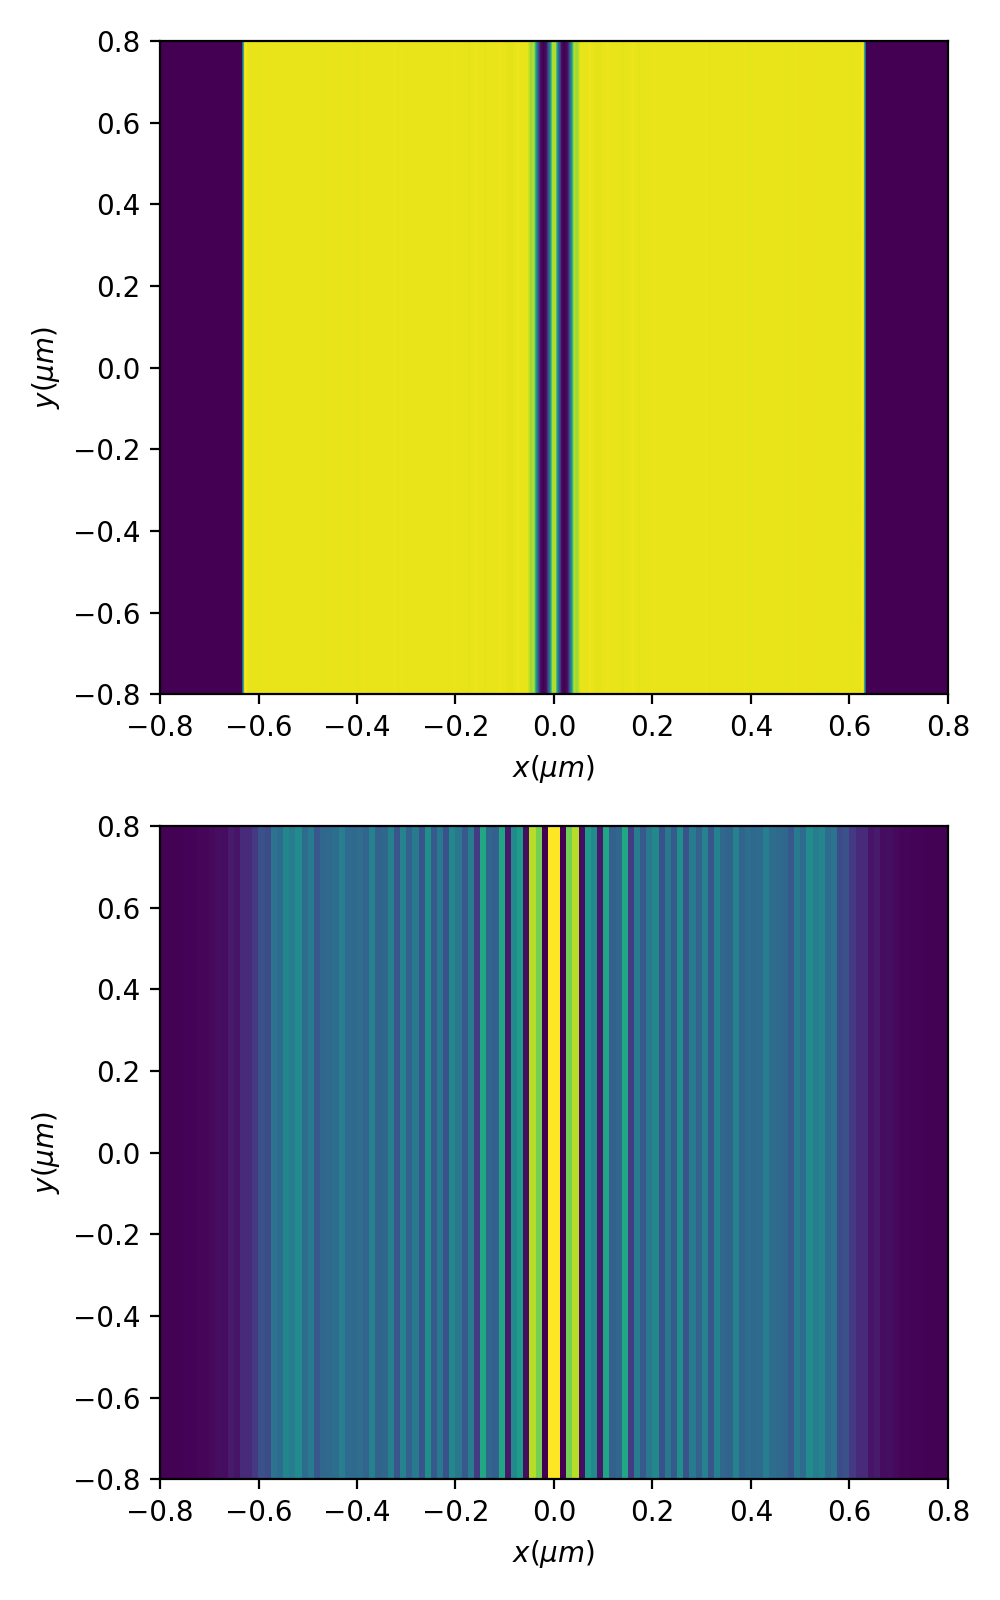

In [24]:
import scipy 
from collections import defaultdict

def plot_interference(x_out, y_out, z_eval, phase_out, z_plane_idx, scale, fig, ax):

    x_left  = -0.8 #scale[0]
    x_right = 0.8 #scale[1]
    y_bottom  = -0.8
    y_top = 0.8

    x_edge = np.abs(x_left) + np.abs(x_right)
    y_edge = np.abs(y_bottom) + np.abs(y_top)
    
    pixels_x_edge = 256
    pixels_y_edge = 256
    
    image = np.zeros((pixels_x_edge, pixels_y_edge), np.float64)

    pixel_size_x = (x_edge)/pixels_x_edge
    pixel_size_y = (y_edge)/pixels_y_edge
    
    #Create a boolean mask to filter out values outside the valid range of the image plane.
    valid_mask_x = (x_out[:, z_plane_idx] > x_left) & (x_out[:, z_plane_idx] < x_right)
    valid_mask_y = (y_out[:, z_plane_idx] > y_bottom) & (y_out[:, z_plane_idx] < y_top)
    
    valid_mask_combined = np.logical_and(valid_mask_x, valid_mask_y)
    phase_out_valid = phase_out[valid_mask_combined]

    #Filter the coordinates to keep only the valid ones
    x_out_valid = x_out[valid_mask_combined, z_plane_idx]
    y_out_valid = y_out[valid_mask_combined, z_plane_idx]

    #Create the pixel bins
    bins_x = np.arange(x_left, x_right+pixel_size_x, pixel_size_x)
    bins_y = np.arange(y_bottom, y_top+pixel_size_x, pixel_size_x)

    #This histogram is used for testing mainly to make sure my coordinates were being counted in the right pixel.
    hist, xbins, ybins = np.histogram2d(x_out_valid, y_out_valid, bins=(bins_x, bins_y))

    x_bin_indices = np.digitize(x_out_valid, xbins) - 1
    y_bin_indices = np.digitize(y_out_valid, ybins) - 1

    bin_values = defaultdict(list)

    for i, (x_idx, y_idx) in enumerate(zip(x_bin_indices, y_bin_indices)):
        bin_values[(x_idx, y_idx)].append(phase_out_valid[i])  

    #Loop through the coordinates, find the phases of all the rays in each pixel, and calculate the interference. 
    for x, y in bin_values:
        phases = np.array(bin_values[x, y])
        image[x, y] = np.abs(np.sum(np.exp(1j*(phases))/len(phases)))**2

    extension = (x_left, x_right, y_bottom, y_top)
    
    #Plot the intensity image
    ax.imshow((np.abs(image.T)**2), 
                interpolation='bilinear',
                aspect='auto',
                extent = [x_left, x_right, y_bottom, y_top], 
                origin = 'lower')
    
    ax.set_xlabel(xlabel="$x  (\mu m)$")
    ax.set_ylabel(ylabel="$y  (\mu m)$")
    ax.axis(extension)
    
    return fig, ax

fig, ax = plt.subplots(2, 1, figsize=(5, 8), dpi=200)
fractional_wavelength = opl_out[:, -1]/wavelength
phase_out = np.mod(fractional_wavelength*2*np.pi, 2*np.pi)
    
scale = get_scale(x_out[:, -1], y_out[:, -1])
opd_fig, opd_ax = plot_interference(x_out, y_out, z_eval, phase_out, -1, scale, fig, ax[0])  

ax[1].imshow(intensity,
            aspect='auto',
            origin='lower',
            extent=extension)

ax[1].set_xlabel(xlabel="$x  (\mu m)$")
ax[1].set_ylabel(ylabel="$y  (\mu m)$")
ax[1].axis(extension)
plt.tight_layout()